In [1]:
!pip install tensorflow-model-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 12.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_model_optimization.sparsity import keras as sparsity
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.layers import Conv3D,Conv2D,Conv1D,MaxPooling1D, MaxPooling2D,TimeDistributed,LSTM,ConvLSTM2D, GRU
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from keras.layers import TimeDistributed
import seaborn as sns
import h5py
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
activityIDdict = {0: 'transient',
              1: 'lying',# no change in index
              2: 'sitting',# no change in index
              3: 'standing',# no change in index
              4: 'walking',# no change in index
              5: 'running',# no change in index
              6: 'cycling',# no change in index
              7: 'Nordic_walking',# no change in index
              9: 'watching_TV', # not in dataset
              10: 'computer_work',# not in dataset
              11: 'car driving', # not in dataset
              12: 'ascending_stairs', # new index:8
              13: 'descending_stairs', # new index:9
              16: 'vacuum_cleaning', # new index:10
              17: 'ironing', # new index:11
              18: 'folding_laundry',# not in dataset
              19: 'house_cleaning', # not in dataset
              20: 'playing_soccer', # not in dataset
              24: 'rope_jumping' # new index: 0 
              }
#{24:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,12:8,13:9,16:10,17:11}

In [4]:
df= pd.read_table('/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject101.dat', header=None, sep='\s+')

In [5]:
['rope_jumping','lying','sitting','standing','walking','running','cycling','Nordic_walking','ascending_stairs','descending_stairs','vacuum_cleaning','ironing']

['rope_jumping',
 'lying',
 'sitting',
 'standing',
 'walking',
 'running',
 'cycling',
 'Nordic_walking',
 'ascending_stairs',
 'descending_stairs',
 'vacuum_cleaning',
 'ironing']

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0


In [7]:
def read_files():
    list_of_files = ['/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject101.dat',
                     '/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject102.dat',
                     '/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject103.dat',
                     '/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject104.dat',
                     '/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject105.dat',
                     '/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject106.dat',
                     '/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject107.dat',
                     '/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject108.dat',
                     '/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject109.dat' ]
    
    subjectID = [1,2,3,4,5,6,7,8,9]
    

    
    colNames = ["timestamp", "activityID","heartrate"]
    
    IMUhand = ['handTemperature', 
               'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
               'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
               'handGyro1', 'handGyro2', 'handGyro3', 
               'handMagne1', 'handMagne2', 'handMagne3',
               'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']
    
    IMUchest = ['chestTemperature', 
               'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
               'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
               'chestGyro1', 'chestGyro2', 'chestGyro3', 
               'chestMagne1', 'chestMagne2', 'chestMagne3',
               'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']
    
    
    IMUankle = ['ankleTemperature', 
               'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
               'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
               'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
               'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
               'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']
    
    columns = colNames + IMUhand + IMUchest + IMUankle
    
    dataCollection = pd.DataFrame()
    for file in list_of_files:
        print(file," is reading...")
        procData = pd.read_table(file, header=None, sep='\s+')
        procData.columns = columns
        procData['subject_id'] = int(file[-5])
        dataCollection = dataCollection.append(procData, ignore_index=True)
        
    print("all files have been read...")
        
    dataCollection.reset_index(drop=True, inplace=True)
    
    return dataCollection

In [8]:
data = read_files()

/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject101.dat  is reading...
/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject102.dat  is reading...
/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject103.dat  is reading...
/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject104.dat  is reading...
/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject105.dat  is reading...
/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject106.dat  is reading...
/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject107.dat  is reading...
/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject108.dat  is reading...
/content/gdrive/MyDrive/PAMAP2_Dataset/Protocol/subject109.dat  is reading...
all files have been read...


In [9]:
data.head()
data[data['subject_id']==1]

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,1
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,1
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,1
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,1
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376412,3772.50,0,NaN,30.5,2.02477,7.29553,5.74194,2.06573,6.57692,5.92695,...,-0.008034,0.018600,-58.8381,-36.2397,-11.0980,1.0,0.0,0.0,0.0,1
376413,3772.51,0,NaN,30.5,2.10836,7.86504,5.85674,2.08754,7.42244,5.87977,...,0.024647,0.013375,-58.9537,-36.3379,-11.7170,1.0,0.0,0.0,0.0,1
376414,3772.52,0,NaN,30.5,2.07163,8.39581,5.77742,2.13833,8.05640,5.90853,...,0.026009,0.025054,-59.1781,-35.8985,-10.9678,1.0,0.0,0.0,0.0,1
376415,3772.53,0,NaN,30.5,2.19569,8.77634,6.00892,2.11251,8.53989,5.93770,...,-0.035531,0.024640,-58.8299,-36.6845,-10.8553,1.0,0.0,0.0,0.0,1


### 2. Data Cleaning


In [10]:
data['heartrate'].isnull().sum()/len(data['heartrate']) *100
## the feature 'heartrate' has over 90% of NAN values

90.86980027731623

In [11]:
def dataCleaning(dataCollection):
    dataCollection = dataCollection.drop(['timestamp', 'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
                                         'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
                                         'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'],
                                         axis = 1)  # removal of orientation columns as they are not needed
    dataCollection = dataCollection.drop(dataCollection[dataCollection.activityID == 0].index) #removal of any row of activity 0 as it is transient activity which it is not used
    dataCollection = dataCollection.apply(pd.to_numeric, errors = 'coerce') #removal of non numeric data in cells
    dataCollection = dataCollection.drop('heartrate',axis=1)#as 98% of rows has null value
    dataCollection = dataCollection.dropna()
    print("data cleaned!")
    return dataCollection

In [12]:
cleaned_data = dataCleaning(data)

data cleaned!


In [13]:
cleaned_data.head()

,activityID,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id
2928,1,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,-0.004750,0.037579,...,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,1
2929,1,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,-0.171710,0.025479,...,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,1
2930,1,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,-0.238241,0.011214,...,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,1
2931,1,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,-0.192912,0.019053,...,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,1
2932,1,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,-0.069961,-0.018328,...,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,1


In [14]:
def reset_label(dataCollection): 
    # Convert original labels {1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24} to new labels. 
    mapping = {24:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,12:8,13:9,16:10,17:11} # old activity Id to new activity Id 
    for i in [24,12,13,16,17]:
        dataCollection.loc[dataCollection.activityID == i, 'activityID'] = mapping[i]

    return dataCollection


In [15]:
data_reset = reset_label(cleaned_data)  

In [16]:
def class_breakdown(data,col):
    # group data by the class value and calculate the number of rows
    counts = data.groupby(col).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(data) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

In [17]:
class_breakdown(data_reset,'activityID')

Class=1, total=47579, percentage=2.476
Class=2, total=192290, percentage=10.008
Class=3, total=184645, percentage=9.610
Class=4, total=188984, percentage=9.836
Class=5, total=229709, percentage=11.955
Class=6, total=95641, percentage=4.978
Class=7, total=163302, percentage=8.499
Class=8, total=184444, percentage=9.599
Class=9, total=117094, percentage=6.094
Class=10, total=104865, percentage=5.458
Class=11, total=174976, percentage=9.107
Class=12, total=237902, percentage=12.382


In [18]:
X=data_reset.drop(['activityID'],axis=1)
y=data_reset['activityID']

we found that class imbalance is present there in the dataset


### 3. Under Sample using NearMiss (version=1)
we are using under sampling to sample the data as there millions of records in the dataset

In [19]:
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import LabelEncoder
def sampling(X,y):
    y_encoded = LabelEncoder().fit_transform(y)
    undersample = NearMiss(version=1)
    X_sampled,y_sampled=undersample.fit_resample(X,y_encoded)
    return X_sampled,y_sampled

In [20]:
X_sampled,y_sampled=sampling(X,y)

In [21]:
X_=X_sampled.drop('subject_id',axis=1)
X_subID=X_sampled['subject_id']

### 4. Scaling using MIN_MAX scaler

In [22]:
def scale(df):#pandas dataframe 
    features=df.columns[0:39]
    scaler = MinMaxScaler(feature_range=(-1,1))
    #scaler = StandardScaler()
    #df.iloc[:,[1,-1]] = scaler.fit_transform(df.iloc[:,[1,-1]])
    df[features]=scaler.fit_transform(df[features])
    #df=scaler.fit_transform(df)
    return df

In [23]:
data_scaled =scale(X_)

In [24]:
data_scaled.shape

(570948, 39)

In [25]:
X_sampled_scaled=pd.concat([pd.DataFrame(y_sampled,columns = ['activityID']),pd.DataFrame(data_scaled)],axis=1)

In [26]:
X_sampled_scaled=pd.concat([pd.DataFrame(X_sampled_scaled),pd.DataFrame(X_subID,columns = ['subject_id'])],axis=1)

In [27]:
X_sampled_scaled[X_sampled_scaled['subject_id']==1]

,activityID,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,...,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id
0,0,0.000000,0.582383,0.212703,-0.561298,0.562925,0.103353,0.043748,0.132603,-0.126435,...,0.146034,-0.026100,0.155555,0.187146,0.140922,-0.170805,-0.189001,0.418305,-0.461998,1
1,0,0.000000,0.578270,0.214282,-0.558970,0.561514,0.107877,0.044565,0.129600,-0.126985,...,0.145298,-0.025856,0.156153,0.186261,0.142555,-0.170401,-0.206053,0.423275,-0.473034,1
2,0,0.000000,0.575302,0.210668,-0.563306,0.559691,0.108639,0.045814,0.126588,-0.128092,...,0.144808,-0.025611,0.156452,0.188107,0.143635,-0.166816,-0.200219,0.413122,-0.465169,1
3,0,0.000000,0.575302,0.195369,-0.560908,0.556952,0.100118,0.038355,0.123791,-0.127763,...,0.144804,-0.025612,0.155264,0.187273,0.140692,-0.167630,-0.200290,0.417363,-0.466728,1
4,0,0.000000,0.579624,0.203510,-0.562079,0.556112,0.089587,0.042141,0.128218,-0.127336,...,0.144806,-0.025856,0.155859,0.187279,0.139304,-0.168035,-0.194790,0.424258,-0.471513,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570823,11,0.588235,0.644669,0.172532,-0.563923,0.634265,0.066371,0.040053,0.162919,-0.125323,...,0.162001,-0.008210,0.222824,0.083844,0.182750,-0.204519,-0.166470,-0.270121,0.310251,1
570832,11,0.564706,0.612712,0.210675,-0.548116,0.599067,0.110477,0.087806,0.087984,-0.085186,...,0.146593,-0.009239,0.173609,0.184505,0.139583,-0.168210,-0.213074,-0.165675,0.298939,1
570899,11,0.588235,0.439615,0.195959,-0.564177,0.416797,0.087256,0.034817,0.081955,-0.123723,...,0.134845,0.048618,0.182667,0.172377,0.156948,-0.172809,-0.199872,-0.429908,0.255842,1
570930,11,0.576471,0.574327,0.194468,-0.551084,0.559568,0.085570,0.067960,0.132166,-0.132640,...,0.146343,-0.010949,0.172726,0.185717,0.144283,-0.169214,-0.210238,-0.164432,0.303742,1


### 5. Segmenting the sampled&scaled data into fixed sized window

In [28]:
def segment_signal(data, window_size): # data is numpy array
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0
    while start + window_size - 1 < n:
        end = start + window_size-1
        # if the frame contains the same activity and from the same object
        X.append(data[start:(end+1),1:-1])
        y.append(data[start][0])
        start += window_size//2 # 50% overlap
    print(np.asarray(X).shape, np.asarray(y).shape)
    return {'inputs' : np.asarray(X), 'labels': np.asarray(y,dtype=int)}


In [29]:
# data segmented
window_size=128

data_segmented=segment_signal(X_sampled_scaled.to_numpy(),window_size)

(8920, 128, 39) (8920,)


### 6. Saving the into h5 format

In [30]:
def save_data(data,file_name): # save the data in h5 format
    f = h5py.File(file_name,'w')
    for key in data:
        print(key)
        f.create_dataset(key,data = data[key])       
    f.close()
    print('Done.')    

In [ ]:
#file_name = 'pamap_scaled.h5'


In [31]:
file_name = 'pamap_sampled_scaled_segmented.h5'

In [32]:
save_data(data_segmented, file_name)

inputs
labels
Done.


In [33]:
path = "/content/pamap_sampled_scaled_segmented.h5"

In [34]:
f = h5py.File(path, 'r')
X = f.get('inputs')
y = f.get('labels') 
print(type(X))
print(type(y))
X = np.array(X)
y = np.array(y)

<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>


In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state = 100)
X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.3, random_state = 100)

In [37]:
from keras.utils import to_categorical
trainy_one_hot = to_categorical(y_train)
testy_one_hot = to_categorical(y_test)

In [38]:
X_train.shape, X_test.shape

((4370, 128, 39), (2676, 128, 39))

In [39]:
y_train.shape, y_test.shape

((4370,), (2676,))

In [40]:
y_val_hot = to_categorical(y_val)

In [41]:
trainy_one_hot.shape#, testy_one_hot.shape

(4370, 12)

In [42]:
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = pd.DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

In [43]:
class_breakdown(y_train)

Class=1, total=352, percentage=8.055
Class=2, total=347, percentage=7.941
Class=3, total=374, percentage=8.558
Class=4, total=367, percentage=8.398
Class=5, total=361, percentage=8.261
Class=6, total=361, percentage=8.261
Class=7, total=368, percentage=8.421
Class=8, total=365, percentage=8.352
Class=9, total=372, percentage=8.513
Class=10, total=368, percentage=8.421
Class=11, total=368, percentage=8.421
Class=12, total=367, percentage=8.398


In [44]:
class_breakdown(y_test)

Class=1, total=246, percentage=9.193
Class=2, total=229, percentage=8.558
Class=3, total=206, percentage=7.698
Class=4, total=212, percentage=7.922
Class=5, total=217, percentage=8.109
Class=6, total=227, percentage=8.483
Class=7, total=221, percentage=8.259
Class=8, total=229, percentage=8.558
Class=9, total=218, percentage=8.146
Class=10, total=232, percentage=8.670
Class=11, total=225, percentage=8.408
Class=12, total=214, percentage=7.997


In [45]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], trainy_one_hot.shape[1]

In [79]:
n_timesteps, n_features, n_outputs

(128, 39, 12)

**Build and train the model**

# **CNN-LSTM**

In [80]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(units=64, activation='tanh', dropout=0.5),
    tf.keras.layers.Dense(n_outputs, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 126, 64)           7552      
                                                                 
 conv1d_9 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 62, 64)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 12)                780       
                                                                 
Total params: 53,708
Trainable params: 53,708
Non-trainable params: 0
__________________________________________________

In [81]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [82]:
history = model.fit(X_train, trainy_one_hot, validation_data=(X_val, y_val_hot), epochs=10, batch_size=32)

Epoch 1/10
137/137 [==============================] - 6s 16ms/step - loss: 0.9900 - accuracy: 0.7119 - val_loss: 0.2692 - val_accuracy: 0.9477
Epoch 2/10
137/137 [==============================] - 1s 8ms/step - loss: 0.3131 - accuracy: 0.9192 - val_loss: 0.4653 - val_accuracy: 0.8602
Epoch 3/10
137/137 [==============================] - 1s 8ms/step - loss: 0.1516 - accuracy: 0.9698 - val_loss: 0.0614 - val_accuracy: 0.9909
Epoch 4/10
137/137 [==============================] - 1s 9ms/step - loss: 0.0832 - accuracy: 0.9838 - val_loss: 0.0596 - val_accuracy: 0.9851
Epoch 5/10
137/137 [==============================] - 1s 8ms/step - loss: 0.2648 - accuracy: 0.9304 - val_loss: 0.0683 - val_accuracy: 0.9920
Epoch 6/10
137/137 [==============================] - 1s 9ms/step - loss: 0.0890 - accuracy: 0.9824 - val_loss: 0.0400 - val_accuracy: 0.9920
Epoch 7/10
137/137 [==============================] - 1s 11ms/step - loss: 0.0368 - accuracy: 0.9934 - val_loss: 0.0285 - val_accuracy: 0.9947
Epoc

In [83]:
test_loss, test_acc = model.evaluate(X_val, y_val_hot)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

59/59 [==============================] - 0s 4ms/step - loss: 0.0237 - accuracy: 0.9968
Test loss: 0.02369660697877407
Test accuracy: 0.9967982769012451


In [84]:
import matplotlib.pyplot as plt

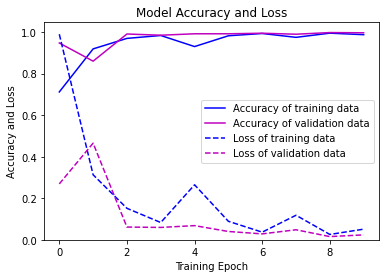

In [85]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'b', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'm', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'b--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'm--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

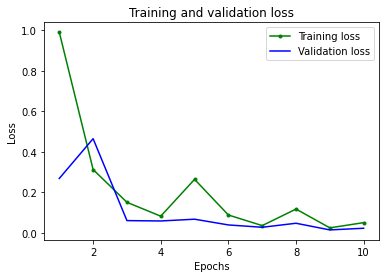

[6.0, 4.0]


In [86]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (6,4)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', linestyle='solid', label='Training loss')
plt.plot(epochs, val_loss, 'b', linestyle='solid', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

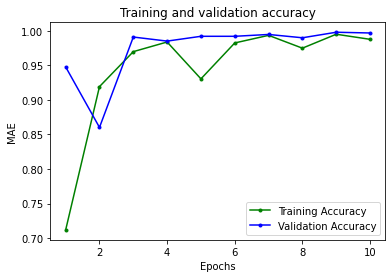

In [87]:
# graph of mean absolute error
mae = history.history['accuracy']
val_mae = history.history['val_accuracy']
plt.plot(epochs, mae, 'g.', linestyle='solid', label='Training Accuracy')
plt.plot(epochs, val_mae, 'b.', linestyle='solid', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

**Confusion matrix**

In [88]:
# use the model to predict the test inputs
predictions = model.predict(X_val)

59/59 [==============================] - 1s 3ms/step


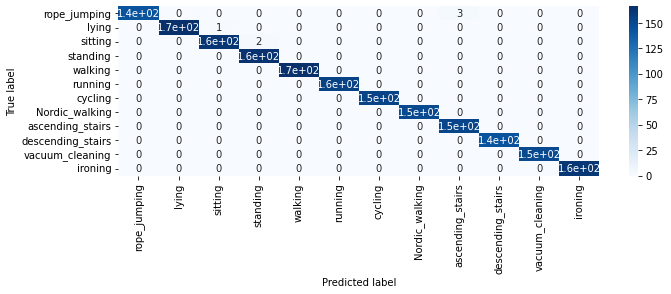

In [89]:
cm = tf.math.confusion_matrix(labels=tf.argmax(y_val_hot, 1), predictions=tf.argmax(predictions, 1))
axis_labels = axis_labels = ['rope_jumping','lying','sitting','standing','walking','running','cycling','Nordic_walking','ascending_stairs','descending_stairs','vacuum_cleaning','ironing']
figure = plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues,xticklabels=axis_labels, yticklabels=axis_labels)
plt.ylim(len(cm)-0, 0)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# CNN

In [50]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(n_outputs, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 126, 64)           7552      
                                                                 
 conv1d_5 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 62, 64)           0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 60, 64)            12352     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 30, 64)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 28, 64)           

In [51]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
history = model.fit(X_train, trainy_one_hot, validation_data=(X_val, y_val_hot), epochs=10, batch_size=32)

Epoch 1/10
137/137 [==============================] - 13s 10ms/step - loss: 0.6928 - accuracy: 0.7778 - val_loss: 0.0918 - val_accuracy: 0.9829
Epoch 2/10
137/137 [==============================] - 1s 6ms/step - loss: 0.0636 - accuracy: 0.9876 - val_loss: 0.0635 - val_accuracy: 0.9867
Epoch 3/10
137/137 [==============================] - 1s 6ms/step - loss: 0.0508 - accuracy: 0.9899 - val_loss: 0.0260 - val_accuracy: 0.9952
Epoch 4/10
137/137 [==============================] - 1s 6ms/step - loss: 0.0290 - accuracy: 0.9945 - val_loss: 0.0164 - val_accuracy: 0.9957
Epoch 5/10
137/137 [==============================] - 1s 6ms/step - loss: 0.0261 - accuracy: 0.9934 - val_loss: 0.0386 - val_accuracy: 0.9861
Epoch 6/10
137/137 [==============================] - 1s 7ms/step - loss: 0.0305 - accuracy: 0.9911 - val_loss: 0.0137 - val_accuracy: 0.9968
Epoch 7/10
137/137 [==============================] - 1s 6ms/step - loss: 0.0136 - accuracy: 0.9968 - val_loss: 0.0038 - val_accuracy: 0.9989
Epoc

In [53]:
test_loss, test_acc = model.evaluate(X_val, y_val_hot)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

59/59 [==============================] - 0s 4ms/step - loss: 0.0094 - accuracy: 0.9973
Test loss: 0.009368588216602802
Test accuracy: 0.9973319172859192


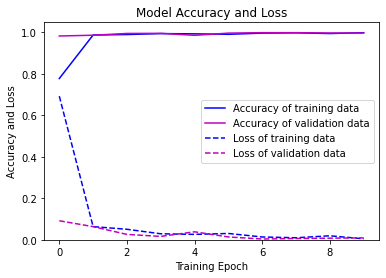

In [55]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'b', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'm', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'b--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'm--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

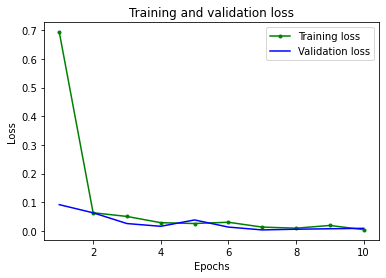

[6.0, 4.0]


In [56]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (6,4)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', linestyle='solid', label='Training loss')
plt.plot(epochs, val_loss, 'b', linestyle='solid', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

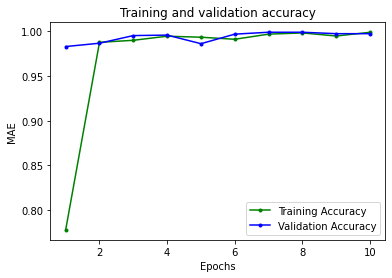

In [57]:
# graph of mean absolute error
mae = history.history['accuracy']
val_mae = history.history['val_accuracy']
plt.plot(epochs, mae, 'g.', linestyle='solid', label='Training Accuracy')
plt.plot(epochs, val_mae, 'b.', linestyle='solid', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

**Confusion Matrix**

In [58]:
# use the model to predict the test inputs
predictions = model.predict(X_val)

59/59 [==============================] - 0s 2ms/step


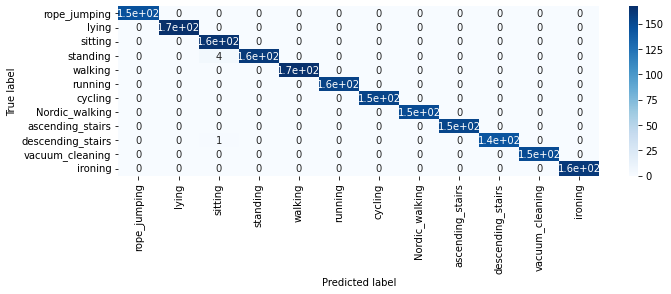

In [60]:
cm = tf.math.confusion_matrix(labels=tf.argmax(y_val_hot, 1), predictions=tf.argmax(predictions, 1))
axis_labels = ['rope_jumping','lying','sitting','standing','walking','running','cycling','Nordic_walking','ascending_stairs','descending_stairs','vacuum_cleaning','ironing']
figure = plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues,xticklabels=axis_labels, yticklabels=axis_labels)
plt.ylim(len(cm)-0, 0)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **CNN-GRU**

In [135]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GRU(units=64, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(n_outputs, activation='softmax')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 126, 64)           7552      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 63, 64)           0         
 1D)                                                             
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 12)                780       
                                                                 
Total params: 33,292
Trainable params: 33,292
Non-trainable params: 0
__________________________________________________

In [136]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [137]:
history = model.fit(X_train, trainy_one_hot, validation_data=(X_val, y_val_hot), epochs=10, batch_size=32)

Epoch 1/10
137/137 [==============================] - 6s 13ms/step - loss: 1.4472 - accuracy: 0.5172 - val_loss: 0.4178 - val_accuracy: 0.9349
Epoch 2/10
137/137 [==============================] - 1s 8ms/step - loss: 0.3119 - accuracy: 0.9378 - val_loss: 0.1095 - val_accuracy: 0.9861
Epoch 3/10
137/137 [==============================] - 1s 8ms/step - loss: 0.1240 - accuracy: 0.9865 - val_loss: 0.0777 - val_accuracy: 0.9851
Epoch 4/10
137/137 [==============================] - 1s 9ms/step - loss: 0.0976 - accuracy: 0.9856 - val_loss: 0.0712 - val_accuracy: 0.9808
Epoch 5/10
137/137 [==============================] - 1s 8ms/step - loss: 0.0813 - accuracy: 0.9872 - val_loss: 0.0393 - val_accuracy: 0.9931
Epoch 6/10
137/137 [==============================] - 2s 12ms/step - loss: 0.0492 - accuracy: 0.9950 - val_loss: 0.0218 - val_accuracy: 0.9941
Epoch 7/10
137/137 [==============================] - 2s 17ms/step - loss: 0.0734 - accuracy: 0.9883 - val_loss: 0.0212 - val_accuracy: 0.9957
Epo

In [138]:
test_loss, test_acc = model.evaluate(X_val, y_val_hot)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

59/59 [==============================] - 0s 5ms/step - loss: 0.0217 - accuracy: 0.9957
Test loss: 0.021744301542639732
Test accuracy: 0.9957310557365417


In [139]:
import matplotlib.pyplot as plt

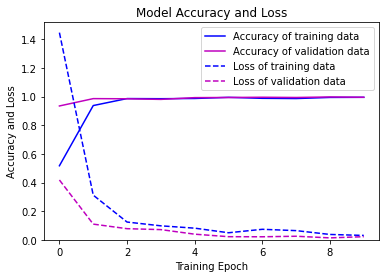

In [140]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'b', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'm', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'b--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'm--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

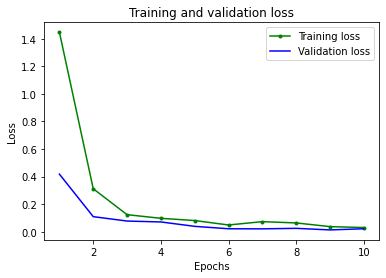

[6.0, 4.0]


In [141]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (6,4)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', linestyle='solid', label='Training loss')
plt.plot(epochs, val_loss, 'b', linestyle='solid', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

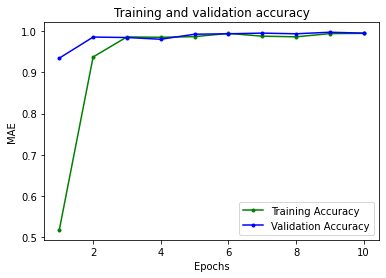

In [142]:
# graph of mean absolute error
mae = history.history['accuracy']
val_mae = history.history['val_accuracy']
plt.plot(epochs, mae, 'g.', linestyle='solid', label='Training Accuracy')
plt.plot(epochs, val_mae, 'b.', linestyle='solid', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [143]:
# use the model to predict the test inputs
predictions = model.predict(X_val)

59/59 [==============================] - 1s 4ms/step


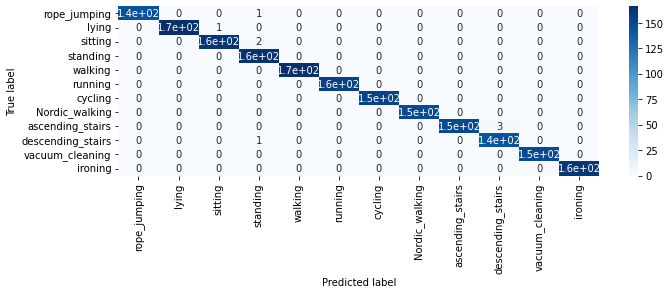

In [144]:
cm = tf.math.confusion_matrix(labels=tf.argmax(y_val_hot, 1), predictions=tf.argmax(predictions, 1))
axis_labels = ['rope_jumping','lying','sitting','standing','walking','running','cycling','Nordic_walking','ascending_stairs','descending_stairs','vacuum_cleaning','ironing']
figure = plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues,xticklabels=axis_labels, yticklabels=axis_labels)
plt.ylim(len(cm)-0, 0)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Save Model

In [117]:
model.save('model.h5')

# code

In [118]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter._experimental_lower_tensor_list_ops = False
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

# Save the model to disk
open("model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("model.tflite")
print("Model is %d bytes" % basic_model_size)

Model is 146416 bytes


In [119]:
# Compile the TensorFlow Lite model into a C source file
!xxd -i model.tflite > model.cc

# Create a header file from the C source file
!sed 's/unsigned/const unsigned/g' model.cc > model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")

Header file, model.h, is 902,987 bytes.


In [120]:
import tensorflow_model_optimization as tfmot

pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
    initial_sparsity=0.0,
    final_sparsity=0.5,
    begin_step=0,
    end_step=1000
)

pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_schedule=pruning_schedule)
pruned_model.summary()

import tempfile

logdir = tempfile.mkdtemp()

callbacks = [
    sparsity.UpdatePruningStep(),
    sparsity.PruningSummaries(log_dir=logdir, profile_batch=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',min_lr=0.0001)

]


pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
his = pruned_model.fit(X_train, trainy_one_hot, epochs = 10, batch_size=32, callbacks=callbacks, validation_data= (X_val, y_val_hot), verbose=1)


score = pruned_model.evaluate(X_val, y_val_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv1d_  (None, 126, 64)          15042     
 10 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_poo  (None, 63, 64)           1         
 ling1d_7 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_gru (Pr  (None, 64)               49539     
 uneLowMagnitude)                                                
                                                                 
 prune_low_magnitude_dropout  (None, 64)               1         
  (PruneLowMagnitude)                                            
                                                      

137/137 [==============================] - 7s 20ms/step - loss: 0.0538 - accuracy: 0.9895 - val_loss: 0.0238 - val_accuracy: 0.9957 - lr: 0.0010
Epoch 2/10
137/137 [==============================] - 2s 14ms/step - loss: 0.0316 - accuracy: 0.9954 - val_loss: 0.0129 - val_accuracy: 0.9984 - lr: 0.0010
Epoch 3/10
137/137 [==============================] - 1s 10ms/step - loss: 0.0316 - accuracy: 0.9961 - val_loss: 0.0189 - val_accuracy: 0.9947 - lr: 0.0010
Epoch 4/10
137/137 [==============================] - 1s 10ms/step - loss: 0.0447 - accuracy: 0.9927 - val_loss: 0.0173 - val_accuracy: 0.9947 - lr: 0.0010
Epoch 5/10
137/137 [==============================] - 1s 10ms/step - loss: 0.0577 - accuracy: 0.9881 - val_loss: 0.0257 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 6/10
137/137 [==============================] - 1s 10ms/step - loss: 0.0341 - accuracy: 0.9961 - val_loss: 0.0101 - val_accuracy: 0.9979 - lr: 0.0010
Epoch 7/10
137/137 [==============================] - 1s 10ms/step - loss: 

In [121]:
core = pruned_model.evaluate(X_val, y_val_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.010208596475422382
Test accuracy: 0.9962646961212158


In [122]:
pruned_model = sparsity.strip_pruning(pruned_model)
pruned_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 126, 64)           7552      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 63, 64)           0         
 1D)                                                             
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 12)                780       
                                                                 
Total params: 33,292
Trainable params: 33,292
Non-trainable params: 0
__________________________________________________

In [123]:
pruned_model.compile(
    loss=["mse"],
    optimizer="adam",
    metrics=['accuracy']
)

59/59 [==============================] - 1s 3ms/step


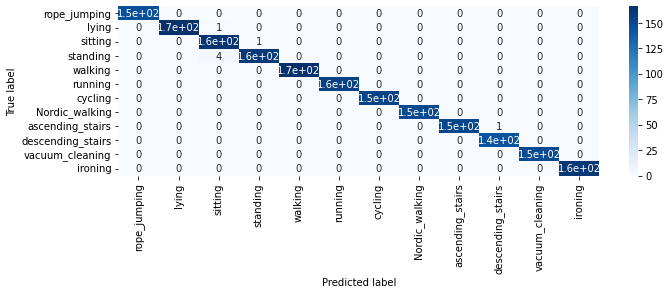

In [124]:
predictions_p = pruned_model.predict(X_val)
cm = tf.math.confusion_matrix(labels=tf.argmax(y_val_hot, 1), predictions=tf.argmax(predictions_p, 1))
axis_labels = ['rope_jumping','lying','sitting','standing','walking','running','cycling','Nordic_walking','ascending_stairs','descending_stairs','vacuum_cleaning','ironing']
figure = plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues,xticklabels=axis_labels, yticklabels=axis_labels)
plt.tight_layout()
plt.ylim(len(cm)-0, 0)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [125]:
from tensorflow.keras.models import load_model
import numpy as np

for i, w in enumerate(pruned_model.get_weights()):
    print(
        "{} -- Total:{}, Zeros: {:.2f}%".format(
            pruned_model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100
        )
    )

conv1d_10/kernel:0 -- Total:7488, Zeros: 50.00%
conv1d_10/bias:0 -- Total:64, Zeros: 0.00%
gru/gru_cell/kernel:0 -- Total:12288, Zeros: 50.00%
gru/gru_cell/recurrent_kernel:0 -- Total:12288, Zeros: 50.00%
gru/gru_cell/bias:0 -- Total:384, Zeros: 0.00%
dense_3/kernel:0 -- Total:768, Zeros: 50.00%
dense_3/bias:0 -- Total:12, Zeros: 0.00%


In [126]:
# Convert pruned model to TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.experimental_lower_tensor_list_ops = False
tflite_pruned_model = converter.convert()

# Save the TFLite model to disk
with open('pruned_model.tflite', 'wb') as f:
    f.write(tflite_pruned_model)

# Print size of TFLite model
pruned_model_size = os.path.getsize("pruned_model.tflite")
print("Pruned model size: %d bytes" % pruned_model_size)

Pruned model size: 51136 bytes


In [127]:
# Compile the TensorFlow Lite model into a C source file
!xxd -i pruned_model.tflite > Pmodel.cc

# Create a header file from the C source file
!sed 's/unsigned/const unsigned/g' Pmodel.cc > Pmodel.h

import os
Pmodel_h_size = os.path.getsize("Pmodel.h")
print(f"Header file, Pmodel.h, is {Pmodel_h_size:,} bytes.")

Header file, Pmodel.h, is 315,440 bytes.


In [128]:
pruned_model.save('pruned_model.h5')

In [129]:
# Define a function to generate representative data for quantization
def representative_data_gen():
  for input_value in np.array(X_train, dtype=np.float32):
    yield [np.expand_dims(input_value, axis=0)]



# Convert the Keras model to a TensorFlow Lite model with quantization
pruned_model = tf.keras.models.load_model('pruned_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
pruned_quantized_tflite_model = converter.convert()

# Save the quantized model to disk
with open("pruned_quantized_model.tflite", "wb") as f:
    f.write(pruned_quantized_tflite_model)

# Check the size of the quantized model
quantized_model_size = os.path.getsize("pruned_quantized_model.tflite")
print("pruned_quantized_model is %d bytes" % quantized_model_size)

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


pruned_quantized_model is 50688 bytes


In [130]:
# Compile the TensorFlow Lite model into a C source file
!xxd -i pruned_quantized_model.tflite > Pqmodel.cc

# Create a header file from the C source file
!sed 's/unsigned/const unsigned/g' Pqmodel.cc > Pqmodel.h

import os
Pqmodel_h_size = os.path.getsize("Pqmodel.h")
print(f"Header file, Pqmodel.h, is {Pqmodel_h_size:,} bytes.")

Header file, Pqmodel.h, is 312,696 bytes.


In [131]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  arr = []
  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(X_val):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    # print(test_image)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)

  for i in range(0,len(y_val_hot)):
    arr.append(np.argmax(y_val_hot[i]))
  accuracy = (prediction_digits == np.array(arr)).mean()
  return accuracy

In [132]:
# Pruned and Quantized model accuracy
interpreter = tf.lite.Interpreter(model_content=pruned_quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', test_accuracy)

Pruned and quantized TFLite test_accuracy: 0.996264674493063


In [133]:
# Pruned model accuracy
interpreter1 = tf.lite.Interpreter(model_content=tflite_pruned_model)
interpreter1.allocate_tensors()

test_accuracy_ = evaluate_model(interpreter1)
print('Pruned TF test accuracy:', test_accuracy_)

Pruned TF test accuracy: 0.996264674493063
